# **TikTok Video Classification: Claim vs. Opinion**
### Problem Statement  
TikTok is one of the most popular social media platforms, where users can upload and share videos. However, with millions of videos being uploaded, there is a challenge in regulating content, especially when users report videos for containing misleading claims. Currently, TikTok moderators manually review these reports, which can lead to delays due to the sheer volume.

To address this, we need to develop a **predictive model** that can automatically classify videos as either containing a claim or an opinion.

### Goal  
The goal is to predict whether a TikTok video presents a "claim" or an "opinion," so that TikTok can efficiently prioritize user reports, allowing moderators to focus on videos that are more likely to present potentially harmful claims. This reduces the burden on moderators and improves the platform’s content management system.

I have broken down the entire process into four stages: **Plan, Analyze, Construct, and Evaluate (PACE)**. The actions performed under each stage are as follows:

- **Plan** – Understanding the data within the problem/business context  
- **Analyze** – Conducting exploratory data analysis and visualizations  
- **Construct** – Comparing machine learning models  
- **Evaluate** – Interpreting the model, assessing its limitations, and providing recommendations


## **Pace: Plan Stage**

Before we just right into the analysis, let us discuss some key points

**1. Business need and modeling objective**

TikTok users can report videos that they believe violate the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, this means that many videos get reported&mdash;too many to be individually reviewed by a human moderator.

Analysis indicates that when authors do violate the terms of service, they're much more likely to be presenting a claim than an opinion. Therefore, it is useful to be able to determine which videos make claims and which videos are opinions.

TikTok wants to build a machine learning model to help identify claims and opinions. Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. For example, perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top x% would be reviewed by a human each day.

A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.

**2. Modeling design and target variable**

The data dictionary used in this analysis shows that there is a column called `claim_status`. This is a binary value that indicates whether a video is a claim or an opinion. This will be the target variable. In other words, for each video, the model should predict whether the video is a claim or an opinion.

This is a **classification task** because the model is predicting a binary class.

**3. Select an evaluation metric**

To determine which evaluation metric might be best, consider how the model might be wrong. There are two possibilities for bad predictions:

  - **False positives:** When the model predicts a video is a claim when in fact it is an opinion
  - **False negatives:** When the model predicts a video is an opinion when in fact it is a claim



**Ethical implications of building the model?**
In the given scenario, it's better for the model to predict false positives when it makes a mistake, and worse for it to predict false negatives. It's very important to identify videos that break the terms of service, even if that means some opinion videos are misclassified as claims. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed _and_ it violates the terms of service. A video that violates the terms of service would be considered posted from a "banned" author, as referenced in the data dictionary.

Because it's more important to minimize false negatives, the model evaluation metric will be **recall**.


**3. Modeling workflow and model selection process**

There are ~20,000 videos (rows) in the sample data. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

1. Split the data into train/validation/test sets (60/20/20)
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)




### **Task 1. Imports and data loading**

We will start by importing packages needed to build machine learning models to achieve the goal of this project.

In [3]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

Load the data from the csv file into a dataframe.

In [4]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

## **PACE: Analyze Stage**

### **Task 2: Examine data, summary info, and descriptive stats**

We will inspect the first five rows of the dataframe.

In [5]:
# Display first few rows
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Get the number of rows and columns in the dataset.

In [6]:
# Get number of rows and columns
data.shape

(19382, 12)

Get basic information about the dataset.

In [7]:
# Get basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


Generate basic descriptive statistics about the dataset.

In [8]:
# Generate basic descriptive stats
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


From the above outputs, we can observe the following:
- The dataframe contains a collection of categorical, text, and numerical data. Each row represents a distinct TikTok video that presents either a claim or an opinion and the accompanying metadata about that video.
- The dataframe contains five float64s, three int64s, and four objects. There are 19,382 observations, but some of the variables are missing values, including claim status, the video transcripton, and all of the count variables.
- Many of the count variables seem to have outliers at the high end of the distribution. They have very large standard deviations and maximum values that are very high compared to their quartile values.

Check for and handle missing values

In [9]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

Note that there are very few missing values relative to the number of samples in the dataset (298/19382). Therefore, observations with missing values can be dropped.

In [10]:
# Drop rows with missing values
data = data.dropna(axis=0)

Check for and handle duplicates

In [11]:
# Check for duplicates
data.duplicated().sum()

0

So, there are no duplicate observations in the data.

### **Task 2b. Understand the data - Investigate the variables**

In this phase, we will begin to investigate the variables more closely to better understand them.

As the ultimate objective for us is to use machine learning to classify videos as either claims or opinions. A good first step towards understanding the data might therefore be examining the `claim_status` variable. Let us begin by determining how many videos there are for each different claim status.

In [ ]:
# What are the different values for claim status and how many of each are in the data?
data['claim_status'].value_counts()

claim      9608
opinion    9476
Name: claim_status, dtype: int64

The counts of each claim status are quite balanced.

Let us now examine the engagement trends associated with each different claim status.

In [ ]:
# What is the average view count of videos with "claim" status?

claims = data[data['claim_status'] == 'claim']
print('Mean view count claims:', claims['video_view_count'].mean())
print('Median view count claims:', claims['video_view_count'].median())

Mean view count claims: 501029.4527477102
Median view count claims: 501555.0


In [ ]:
# What is the average view count of videos with "opinion" status?

opinions = data[data['claim_status'] == 'opinion']
print('Mean view count opinions:', opinions['video_view_count'].mean())
print('Median view count opinions:', opinions['video_view_count'].median())

Mean view count opinions: 4956.43224989447
Median view count opinions: 4953.0


The mean and the median within each claim category are close to one another, but there is a vast discrepancy between view counts for videos labeled as claims and videos labeled as opinions.

Now, examine trends associated with the ban status of the author.

In [ ]:
# Get counts for each group combination of claim status and author ban status

data.groupby(['claim_status', 'author_ban_status']).count()[['#']]

#
claim_status author_ban_status      
claim        active             6566
             banned             1439
             under review       1603
opinion      active             8817
             banned              196
             under review        463

There are many more claim videos with banned authors than opinion videos with banned authors, despite having a comparable number of total claim and opinion videos. This discrepancy could indicate several possibilities, including: 
* Claim videos are more strictly policed than opinion videos
* Authors must comply with a stricter set of rules if they post a claim than if they post an opinion

Also, it should be noted that there's no way of knowing if claim videos are inherently more likely than opinion videos to result in author bans, or if authors who post claim videos are more likely to post videos that violate terms of service.

Finally, while you can use this data to draw conclusions about banned/active authors, you cannot draw conclusions about banned videos. There's no way of determining whether a particular video _caused_ the ban, and banned authors could have posted videos that complied with the terms of service.

Let us Continue investigating engagement levels, now focusing on `author_ban_status`.

Calculate the median video share count of each author ban status.

In [ ]:

round(data.groupby(['author_ban_status']).agg(
    {'video_view_count': ['mean', 'median'],
     'video_like_count': ['mean', 'median'],
     'video_share_count': ['mean', 'median']}),0)

video_view_count           video_like_count            \
                              mean    median             mean    median   
author_ban_status                                                         
active                    215927.0    8616.0          71037.0    2222.0   
banned                    445845.0  448201.0         153017.0  105573.0   
under review              392205.0  365246.0         128718.0   71204.0   

                  video_share_count           
                               mean   median  
author_ban_status                             
active                      14111.0    437.0  
banned                      29999.0  14468.0  
under review                25775.0   9444.0

In [ ]:
# What's the median video share count of each author ban status?

data.groupby(['author_ban_status']).median(numeric_only=True)[
    ['video_share_count']]

,video_share_count
author_ban_status,
active,437.0
banned,14468.0
under review,9444.0


Banned authors have a median share count that's 33 times the median share count of active authors! Let us explore this in more depth.

We can examine `claim_status` and `author_ban_status`

In [ ]:

round(data.groupby(['claim_status','author_ban_status']).agg(
    {'video_view_count': [ 'mean', 'median'],
     'video_like_count': [ 'mean', 'median'],
     'video_share_count': [ 'mean', 'median']
     }),0)

video_view_count           video_like_count  \
                                           mean    median             mean   
claim_status author_ban_status                                               
claim        active                    499222.0  499500.0         164960.0   
             banned                    505908.0  512572.0         173719.0   
             under review              504055.0  500774.0         165567.0   
opinion      active                      4958.0    4958.0           1092.0   
             banned                      4877.0    5084.0           1028.0   
             under review                4958.0    4884.0           1140.0   

                                         video_share_count           
                                  median              mean   median  
claim_status author_ban_status                                       
claim        active             121943.0           32769.0  17774.0  
             banned             132044.0           34057.0  19018.0  
             under review       125882.0           33156.0  18084.0  
opinion      active                820.0             217.0    121.0  
             banned                800.0             208.0    108.0  
             under review          876.0             220.0    124.0

A few observations stand out:
* Banned authors and those under review get far more views, likes, and shares than active authors.
* In most groups, the mean is much greater than the median, which indicates that there are some videos with very high engagement counts.

Now, let us create three new columns to help better understand engagement rates:
* `likes_per_view`: represents the number of likes divided by the number of views for each video
* `comments_per_view`: represents the number of comments divided by the number of views for each video
* `shares_per_view`: represents the number of shares divided by the number of views for each video

In [ ]:
data['likes_per_view'] = data['video_like_count'] / data['video_view_count']
data['comments_per_view'] = data['video_comment_count'] / data['video_view_count']
data['shares_per_view'] = data['video_share_count'] / data['video_view_count']

Examine these engagement rates for each category of `claim_status` and `author_ban_status`  

In [ ]:
data.groupby(['claim_status', 'author_ban_status']).agg(
    {'likes_per_view': ['mean', 'median'],
     'comments_per_view': [ 'mean', 'median'],
     'shares_per_view': ['mean', 'median']})


likes_per_view           comments_per_view  \
                                         mean    median              mean   
claim_status author_ban_status                                              
claim        active                  0.329542  0.326538          0.001393   
             banned                  0.345071  0.358909          0.001377   
             under review            0.327997  0.320867          0.001367   
opinion      active                  0.219744  0.218330          0.000517   
             banned                  0.206868  0.198483          0.000434   
             under review            0.226394  0.228051          0.000536   

                                         shares_per_view            
                                  median            mean    median  
claim_status author_ban_status                                      
claim        active             0.000776        0.065456  0.049279  
             banned             0.000746        0.067893  0.051606  
             under review       0.000789        0.065733  0.049967  
opinion      active             0.000252        0.043729  0.032405  
             banned             0.000193        0.040531  0.030728  
             under review       0.000293        0.044472  0.035027

We know that videos by banned authors and those under review tend to get far more views, likes, and shares than videos by non-banned authors. However, *when a video does get viewed*, its engagement rate is less related to author ban status and more related to its claim status.

Also, we know that claim videos have a higher view rate than opinion videos, but this tells us that claim videos also have a higher rate of likes on average, so they are more favorably received as well. Furthermore, they receive more engagement via comments and shares than opinion videos.

Note that for claim videos, banned authors have slightly higher likes/view and shares/view rates than active authors or those under review. However, for opinion videos, active authors and those under review both get higher engagement rates than banned authors in all categories.

### **Task 2c. Build visualizations**

#### **video_duration_sec**

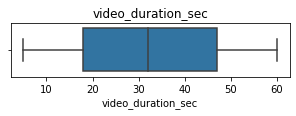

In [ ]:
# Create a boxplot to visualize distribution of `video_duration_sec`
plt.figure(figsize=(5,1))
plt.title('video_duration_sec')
sns.boxplot(x=data['video_duration_sec']);

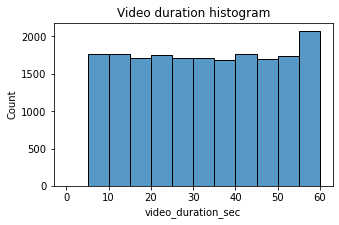

In [ ]:
# Create a histogram to visualize distribution of `video_duration_sec`
plt.figure(figsize=(5,3))
sns.histplot(data['video_duration_sec'], bins=range(0,61,5))
plt.title('Video duration histogram');


All videos are 5-60 seconds in length, and the distribution is uniform.

#### **video_view_count**

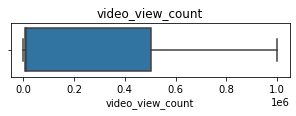

In [ ]:
# Create a boxplot to visualize distribution of `video_view_count`
plt.figure(figsize=(5, 1))
plt.title('video_view_count')
sns.boxplot(x=data['video_view_count']);

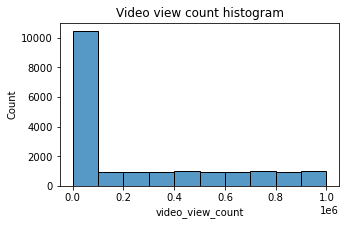

In [ ]:
# Create a histogram of the values in the `video_view_count` 
plt.figure(figsize=(5,3))
sns.histplot(data['video_view_count'], bins=range(0,(10**6+1),10**5))
plt.title('Video view count histogram');

This variable has a very uneven distribution, with more than half the videos receiving fewer than 100,000 views. Distribution of view counts > 100,000 views is uniform.

#### **video_like_count**

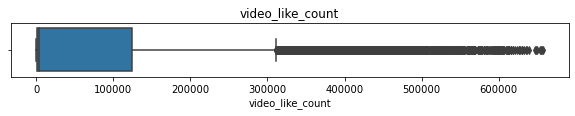

In [ ]:
# Create a boxplot to visualize distribution of `video_like_count`
plt.figure(figsize=(10,1))
plt.title('video_like_count')
sns.boxplot(x=data['video_like_count']);

TypeError: got an unexpected keyword argument 'labels'

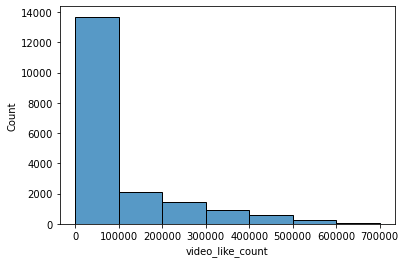

In [ ]:
#Create a histogram of the values in the `video_like_count`
plt.figure(figsize=(5,3))
ax = sns.histplot(data['video_like_count'], bins=range(0,(7*10**5+1),10**5))
labels = [0] + [str(i) + 'k' for i in range(100, 701, 100)]
ax.set_xticks(range(0,7*10**5+1,10**5), labels=labels)
plt.title('Video like count histogram');

Similar to view count, there are far more videos with < 100,000 likes than there are videos with more. However, in this case, there is more of a taper, as the data skews right, with many videos at the upper extremity of like count.

#### **video_comment_count**

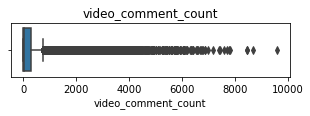

In [ ]:
# Create a boxplot to visualize distribution of `video_comment_count`
plt.figure(figsize=(5,1))
plt.title('video_comment_count')
sns.boxplot(x=data['video_comment_count']);

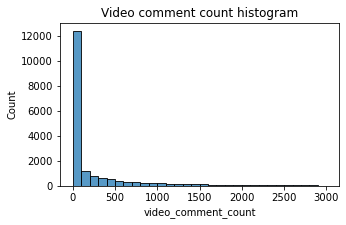

In [ ]:
# Create a histogram to visualize distribution of `video_comment_count`
plt.figure(figsize=(5,3))
sns.histplot(data['video_comment_count'], bins=range(0,(3001),100))
plt.title('Video comment count histogram');

Again, the vast majority of videos are grouped at the bottom of the range of values for video comment count. Most videos have fewer than 100 comments. The distribution is very right-skewed.

#### **video_share_count**

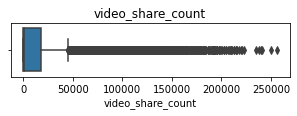

In [ ]:
# Create a boxplot to visualize distribution of `video_share_count`
plt.figure(figsize=(5,1))
plt.title('video_share_count')
sns.boxplot(x=data['video_share_count']);

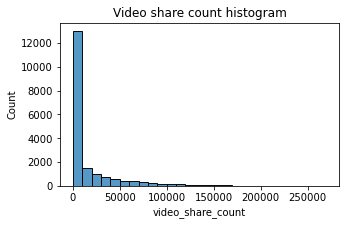

In [ ]:
# Create a boxplot to visualize distribution of `video_share_count`
plt.figure(figsize=(5,3))
sns.histplot(data['video_share_count'], bins=range(0,(270001),10000))
plt.title('Video share count histogram');

The overwhelming majority of videos had fewer than 10,000 shares. The distribution is very skewed to the right.

#### **video_download_count**

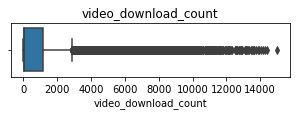

In [ ]:
# Create a boxplot to visualize distribution of `video_download_count`
plt.figure(figsize=(5,1))
plt.title('video_download_count')
sns.boxplot(x=data['video_download_count']);

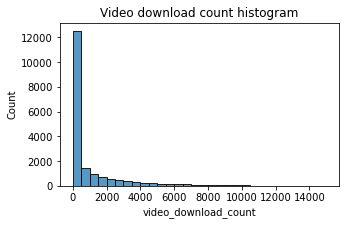

In [ ]:
# Create a boxplot to visualize distribution of `video_download_count`
plt.figure(figsize=(5,3))
sns.histplot(data['video_download_count'], bins=range(0,(15001),500))
plt.title('Video download count histogram');

The majority of videos were downloaded fewer than 500 times, but some were downloaded over 12,000 times. Again, the data is very skewed to the right.

#### **Claim status by verification status**

Now, create a histogram with four bars: one for each combination of claim status and verification status.

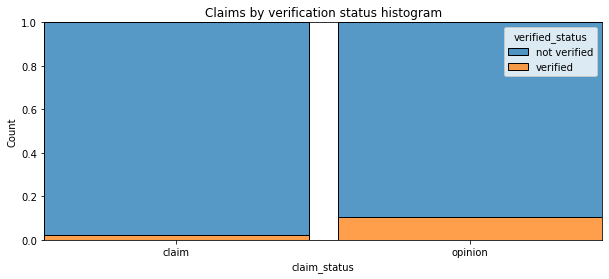

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(data=data,
             x='claim_status',
             hue='verified_status',
             multiple='fill',
             shrink=0.9)
plt.title('Claims by verification status histogram');

There are far fewer verified users than unverified users, but if a user *is* verified, they are much more likely to post opinions.

#### **Claim status by author ban status**

Create histogram to examine the count of each claim status for each author ban status.

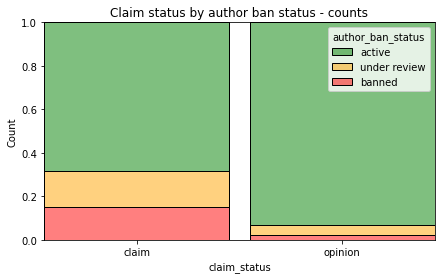

In [ ]:
fig = plt.figure(figsize=(7,4))
sns.histplot(data, x='claim_status', hue='author_ban_status',
             multiple='fill',
             hue_order=['active', 'under review', 'banned'],
             shrink=0.9,
             palette={'active':'green', 'under review':'orange', 'banned':'red'},
             alpha=0.5)
plt.title('Claim status by author ban status - counts');

For both claims and opinions, there are many more active authors than banned authors or authors under review; however, the proportion of active authors is far greater for opinion videos than for claim videos. Again, it seems that authors who post claim videos are more likely to come under review and/or get banned.

#### **Median view counts by ban status**

Let us create a bar plot with three bars: one for each author ban status. The height of each bar will correspond with the median number of views for all videos with that author ban status.

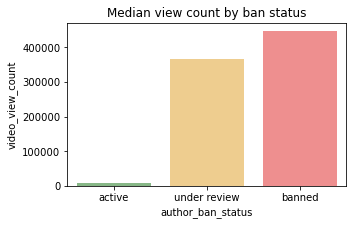

In [ ]:
ban_status_counts = data.groupby(['author_ban_status']).median(
    numeric_only=True).reset_index()

fig = plt.figure(figsize=(5,3))
sns.barplot(data=ban_status_counts,
            x='author_ban_status',
            y='video_view_count',
            order=['active', 'under review', 'banned'],
            palette={'active':'green', 'under review':'orange', 'banned':'red'},
            alpha=0.5)
plt.title('Median view count by ban status');

In [ ]:
data.groupby('claim_status')['video_view_count'].median()

claim_status
claim      501555.0
opinion      4953.0
Name: video_view_count, dtype: float64

The median view counts for non-active authors are significantly higher than the median view count for active authors. Since non-active authors are more likely to post claims, and videos by non-active authors generally receive more views than those by active authors, the `video_view_count` could be a strong indicator of claim status.

Additionally, the median view count by claim status further supports this observation.

#### **Total views by claim status**

Let us create a pie graph that depicts the proportions of total views for claim & opinion videos.

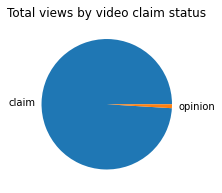

In [ ]:
fig = plt.figure(figsize=(3,3))
plt.pie(data.groupby('claim_status')['video_view_count'].sum(), labels=['claim', 'opinion'])
plt.title('Total views by video claim status');

The overall view count is dominated by claim videos even though there are roughly the same number of each video in the dataset.

### **Task 2d. Determine outliers**

When building predictive models, the presence of outliers can be problematic. For example, when we are trying to predict the view count of a particular video, videos with extremely high view counts might introduce bias to a model. Also, some outliers might indicate problems with how data was captured or recorded.

The ultimate objective of the TikTok project is to build a model that predicts whether a video is a claim or opinion. **The analysis we performed indicates that a video's engagement level is strongly correlated with its claim status.** There's no reason to believe that any of the values in the TikTok data are erroneously captured, and they align with expectation of how social media works: a very small proportion of videos get super high engagement levels. That's the nature of viral content.

Nonetheless, it's good practice to get a sense of just how many of your data points could be considered outliers. **The definition of an outlier can change based on the details of your project, and it helps to have domain expertise to decide a threshold.** A common way to determine outliers in a normal distribution is to calculate the interquartile range (IQR) and set a threshold that is 1.5 * IQR above the **3rd quartile**.

In this TikTok dataset, the values for the count variables are **not normally distributed**. They are heavily skewed to the right. One way of modifying the outlier threshold is by calculating the **median** value for each variable and then adding 1.5 * IQR. This results in a threshold that is, in this case, much lower than it would be if you used the 3rd quartile.

To get the outlier count, let us write a for loop that iterates over the column names of each count variable. For each iteration, it calculates:
1. IQR of the column
2. Median of the column
3. Outlier threshold (median + 1.5 * IQR)
4. Numer of videos with a count in that column that exceeds the outlier threshold

And it finally prints the number of outliers in that respective column.

In [ ]:
count_cols = ['video_view_count',
              'video_like_count',
              'video_share_count',
              'video_download_count',
              'video_comment_count',
              ]

for column in count_cols:
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    median = data[column].median()
    outlier_threshold = median + 1.5*iqr

    # Count the number of values that exceed the outlier threshold
    outlier_count = (data[column] > outlier_threshold).sum()
    print(f'Number of outliers, {column}:', outlier_count)

Number of outliers, video_view_count: 2343
Number of outliers, video_like_count: 3468
Number of outliers, video_share_count: 3732
Number of outliers, video_download_count: 3733
Number of outliers, video_comment_count: 3882


#### **Scatterplot**

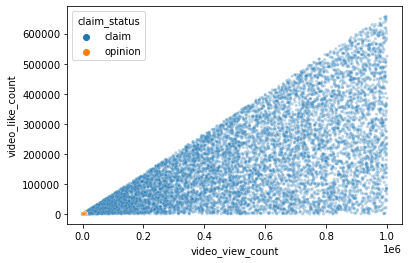

In [ ]:
# Create a scatterplot of `video_view_count` versus `video_like_count` according to 'claim_status'
sns.scatterplot(x=data["video_view_count"], y=data["video_like_count"],
                hue=data["claim_status"], s=10, alpha=.3)
plt.show()

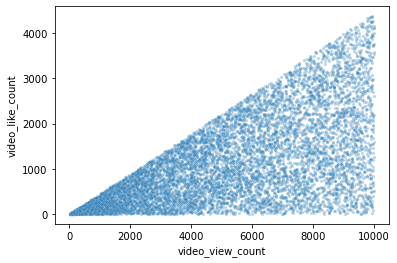

In [ ]:
# Create a scatterplot of `video_view_count` versus `video_like_count` for opinions only
opinion = data[data['claim_status']=='opinion']
sns.scatterplot(x=opinion["video_view_count"], y=opinion["video_like_count"],
                 s=10, alpha=.3)
plt.show()

## **PACE: Construct Stage**

### **Task 3: Feature Engineering**

We observe that the `video_transcription_text` column contains text data. In machine learning, textual data cannot be directly processed by most algorithms because they require numerical inputs to calculate and identify patterns and relationships. However, since text data holds valuable information, we don’t want to exclude it. To address this, we will use the **Tokenize Text** technique to transform the textual information into numerical features. Tokenization breaks down text into smaller units (tokens), such as words or subwords, which can then be converted into numerical representations (like vectors).

As part of feature engineering, we will extract the length (character count) of each `video_transcription_text` and add it to the dataframe as a new column called `text_length` so that it can be used as a feature in the model.

In [13]:
# Create `text_length` column
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Calculate the average `text_length` for claims and opinions.



In [14]:
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


Visualize the distribution of `text_length` for claims and opinions using a histogram.

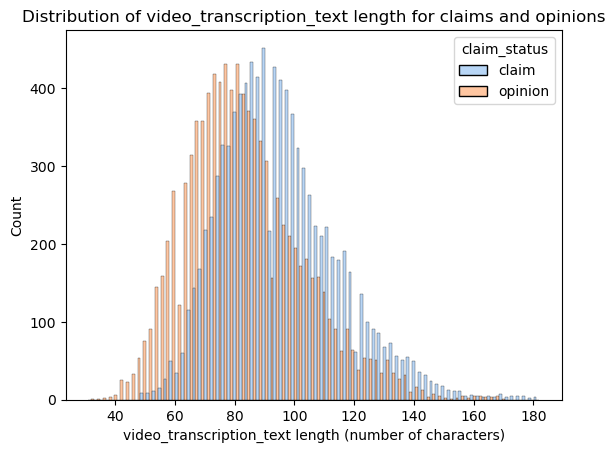

In [15]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot

sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

Letter count distributions for both claims and opinions are approximately normal with a slight right skew. **Claim videos tend to have more characters**&mdash;about 13 more on average, as indicated in a previous cell.

**Feature selection and transformation**

Moreover, we also have categorical variables in our data. As mentioned earlier, most algorithms cannot work with non-numeric data, so we need to encode our categorical variables. Encoding helps represent this information in a way that algorithms can analyze and extract patterns from.

In [16]:
X = data.copy()
# Drop unnecessary columns
X = X.drop(['#', 'video_id'], axis=1)
# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
X = pd.get_dummies(X,
                   columns=['verified_status', 'author_ban_status'],
                   drop_first=True)
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


### **Task 4. Split the data**

Assign target variable.

**Exemplar response:**
In this case, the target variable is `claim_status`.
* 0 represents an opinion
* 1 represents a claim

In [17]:
# Isolate target variable
y = X['claim_status']

Isolate the features.

In [18]:
# Isolate features
X = X.drop(['claim_status'], axis=1)

# Display first few rows of features dataframe
X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


#### **Task 5: Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [19]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [20]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [21]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

- The number of features (`11`) aligns between the training and testing sets.
- The number of rows aligns between the features and the outcome variable for training (`11,450`) and both validation and testing data (`3,817`).

### **Tokenize text column**

**NOTE:** This section is about the tokenizing text columns in our data. We are not expected to do this or know this, but it useful and/or interesting to understand some basic ideas behind natural language processing (NLP), because of the nature of the data provided in this TikTok project.

The feature `video_transcription_text` is text-based. It is not a categorical variable, since it does not have a fixed number of possible values. One way to extract numerical features from it is through a bag-of-words algorithm like [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

`CountVectorizer` works by splitting text into n-grams, which are groups of n consecutive words. For instance, "a dime for a cup of coffee" (phrase A) broken into 2-grams would result in six two-word combinations:

`a dime` | `dime for` |`for a`| `a cup` | `cup of` | `of coffee` |

Then, the next sample's text would be parsed into 2-grams. So, "ask for a cup for a child" (phrase B) would result in:

`ask for` |`for a`| `a cup` | `cup for` | `for a` | `a child` |

This process would repeat for each observation in the dataset, and each n-gram would be treated like a distinct feature. Then, the text of each observation is compared to the full array of n-grams, and the numbers of occurrences are tallied:

|  | `a dime` |`dime for`  |`for a`| `a cup` | `cup of` | `of coffee` | `ask for` | `cup for` | `a child` |
|--: |:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|phrase A |1|1|1|1|1|1|0|0|0|
|phrase B |0|0|2|1|1|0|1|1|1|
|**TOTAL**|1|1|3|2|2|1|1|1|1|

This would happen for the text of each observation in the data, and the text of each observation is parsed to get tallies for all the 2-word phrases from the entire data set for each observation, creating a large matrix.

If text is broken into 1-grams, then each feature in the matrix is an individual word.

After the count matrix has been created, `CountVectorizer` lets you the choose to keep only the most frequently occurring n-grams. You specify how many. The n-grams that you select can then be used as features in a model.

Splitting text into n-grams is an example of tokenization. Tokenization is the process of breaking text into smaller units to derive meaning from the resulting tokens.

This notebook breaks each video's transcription text into both 2-grams and 3-grams, then takes the 15 most frequently occurring tokens from the entire dataset to use as features.

In [22]:
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

Fit the vectorizer to the training data (generate the n-grams) and transform it (tally the occurrences). **We will only fit to the training data, not the validation or test data.**

In [23]:
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [24]:
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Display first few rows
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
# Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`,
# so that the indices align with those in `X_train` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

# Display first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,134,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,False,True,False,...,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,False,False,True,...,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,58,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,57,False,False,False,...,0,0,0,0,0,0,0,0,0,0


Get n-gram counts for the validation data. Notice that the vectorizer is not being refit to the validation data. It's only transforming it. When you only transform data, **you are applying the previously learned vocabulary or model parameters to validation data**. The vectorizer or model does not learn from or adapt to the validation data; it merely converts the validation data into the same format as the training data.

This ensures that the validation data is represented in the same feature space as the training data, using the vocabulary and n-grams learned during training. **This consistency is crucial for evaluating the performance of the model on new, unseen data.**

In [26]:
# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [28]:
# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_val after dropping `video_transcription_text`,
# so that the indices align with those in `validation_count_df`
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)

# Display first few rows
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,False,False,True,...,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,False,False,False,...,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,83,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,104,False,False,True,...,0,0,0,0,0,0,0,1,0,0


Repeat the process to get n-gram counts for the test data. Again, **let's not refit the vectorizer to the test data. Just transform it.**

In [29]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,False,False,False,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,True,False,True,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,76,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,72,False,False,False,...,0,0,0,0,0,0,0,0,0,0


### **Task 6. Build models**

### **Build a random forest model**


Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on **recall**.

In [30]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

Note this cell might take several minutes to run.

In [31]:
%%time
rf_cv.fit(X_train_final, y_train)

CPU times: user 5min 37s, sys: 584 ms, total: 5min 37s
Wall time: 5min 37s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'recall', 'accuracy', 'precision', 'f1'})

In [32]:
# Examine best recall score
rf_cv.best_score_

0.9948228253467271

In [33]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

This model performs exceptionally well, with an average recall score of 0.995 across the five cross-validation folds. After checking the precision score to be sure the model is not classifying all samples as claims, it is clear that this model is making almost perfect classifications.

### **Build an XGBoost model**

In [34]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

Note this cell might take several minutes to run.

In [35]:
%%time
xgb_cv.fit(X_train_final, y_train)

CPU times: user 9min 49s, sys: 2.06 s, total: 9min 51s
Wall time: 5min 1s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring={'recall', 'accuracy', 'precision', 'f1'})

In [36]:
xgb_cv.best_score_

0.9906808769992594

In [37]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

This model also performs exceptionally well. Although its recall score is very slightly lower than the random forest model's, its precision score is perfect.

## **PACE: Execute Stage**

### **Task 7. Evaluate models**

Evaluate models against validation data.


#### **Random forest**

In [38]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val_final)

Display the predictions on the validation set.

In [39]:
# Display the predictions on the validation set
y_pred

array([1, 0, 1, ..., 1, 1, 1])


Display the true labels of the validation set.

In [40]:
# Display the true labels of the validation set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

Create a confusion matrix to visualize the results of the classification model.

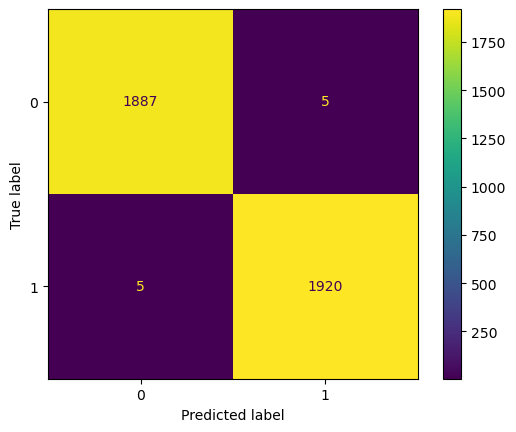

In [41]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

The upper-left quadrant displays the number of true negatives: the number of opinions that the model accurately classified as so.

The upper-right quadrant displays the number of false positives: the number of opinions that the model misclassified as claims.

The lower-left quadrant displays the number of false negatives: the number of claims that the model misclassified as opinions.

The lower-right quadrant displays the number of true positives: the number of claims that the model accurately classified as so.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

As the above confusion matrix shows, this model does not produce any false negatives.

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.

In [42]:
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



The classification report above shows that the random forest model scores were nearly perfect. The confusion matrix indicates that there were 10 misclassifications&mdash;five false postives and five false negatives.

#### **XGBoost**

Now, evaluate the XGBoost model on the validation set.

In [43]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

In [44]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

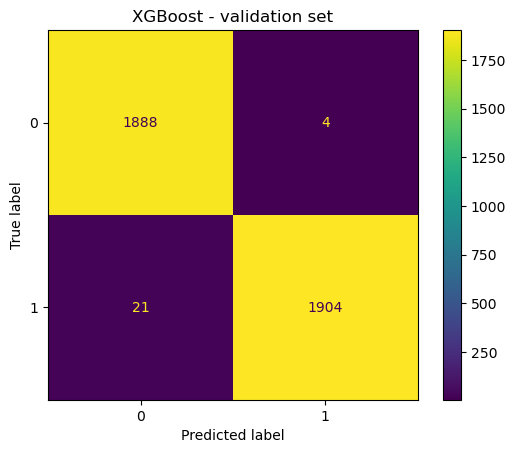

In [45]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()


In [46]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



The results of the XGBoost model were also nearly perfect. However, its errors tended to be false negatives. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos. The random forest model has a better recall score, and is therefore the champion model.

### **Use champion model to predict on test data**

Both random forest and XGBoost model architectures resulted in nearly perfect models. Nonetheless, in this case **random forest** performed a little bit better, so it is the champion model.

Now, use the champion model to predict on the test data.

In [47]:
# Use champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test_final)

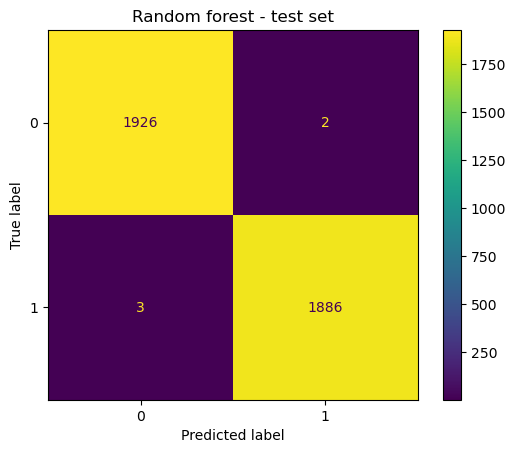

In [48]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random forest - test set');
plt.show()

#### **Feature importances of champion model**



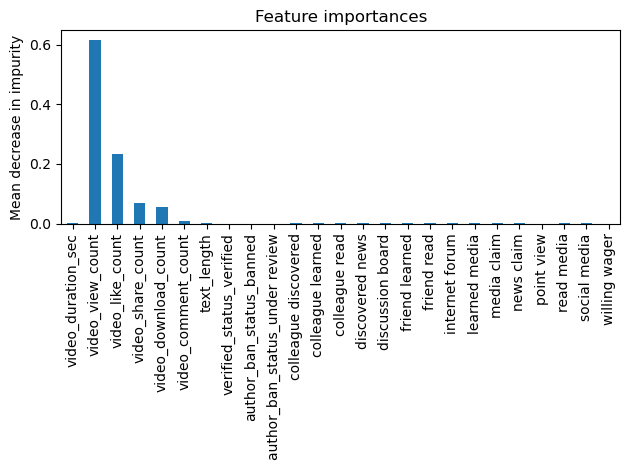

In [49]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

The most **predictive features all were related to engagement levels** generated by the video. This is not unexpected, as analysis from prior EDA pointed to this conclusion.

### **Conclusion**

- The model performed well on both the validation and test holdout data, with consistently high precision and F<sub>1</sub> scores. It effectively classified claims and opinions, making it a reliable model for this task. Therefore, we can confidently recommend this model.

- The most predictive features of the model were related to user engagement levels associated with each video, such as the number of views, likes, shares, and downloads. These features proved to be highly informative for the classification task.

- It is important to note that these engagement levels were not present in the original dataset but were created through feature engineering. This underscores the value of feature engineering: even if a dataset lacks inherently predictive variables, meaningful features can be engineered to build a robust model.

- Given the model’s strong performance, additional data or features may not be necessary at this time. However, potential improvements could include incorporating additional details, such as the number of times a video was reported or the total number of user reports for all videos posted by each author.

- Finally, it is essential to recognize that sometimes the data may not be predictive of the chosen target, which is a common challenge. Machine learning is a powerful tool, but it is not magical. If the data does not contain a predictive signal, even the most sophisticated algorithms will struggle to deliver consistent and accurate predictions.
